###**MODELLO 1F HYPERPARAMETERS** _(~76% sul test set)_

> SEED: 1234

> train_dataset: 80%

> valid_dataset: 20%

> Batch size: 16

> Image w/h: 256

> CNN structure:
>> Filter size: 3x3
>
>> Stripe: 1x1
>
>> Depth: 3 blocks
>
>> Number of filters: 32, 64, 128
>
>> Max pooling size: 2x2, stride 1x1
>
>> Activation function: Relu

> FCN structure:
>> Flatten layer
>
>> 128 neurons (he_uniform)
>
>> BatchNormalization layer
>
>> Activation function: Relu
>
>> Dropout(0.5)
>
>> 3 neurons (Softmax)

> Training parameters:
>> Optimizer: Adam
>
>> Epochs: 50
>
>> Learning rate: 0.001
>
>> Loss: Categorical crossentropy

> Validation loss: 0.8023

> Validation accuracy: ~62%

> Test val: ~66%

In [ ]:
# Helper libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from datetime import datetime

 
# Fixed a seed to make results reproducible 
SEED = 1234
tf.random.set_seed(SEED)

# Getting current main directory
cwd = os.getcwd()

In [ ]:
# Mounting G Drive folder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# CONSTANTS
image_w = 256
image_h = 256
bs = 16
num_classes = 3
num_elements_training = 4491 # Num of images in training dir 
num_elements_validation = 1123 # Num of images in validation dir (calculated as 20% of training)
num_elements_test=450 # Num of images in test dir
epochs=200

In [ ]:
path = '/content/drive/My Drive/Assignment_1/Dataset' # Path to the dataset
dataset_dir = os.path.join(cwd, path)
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

saved_models_dir = os.path.join(cwd, '/content/drive/My Drive/Assignment_1/Saved_Models')
checkpoint_path = os.path.join(cwd, '/content/drive/My Drive/Assignment_1/classification_experiments/FC_Nov12_21-02-23/ckpts/cp.ckpt')

In [ ]:
# Data augmentation
apply_data_augmentation = True

# Creating training ImageDataGenerator object
if apply_data_augmentation:
  train_data_gen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
else:
  train_data_gen = ImageDataGenerator(rescale=1./255)

# Taking the path to a directory and generating batches of augmented data
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(image_h, image_w),
                                               batch_size=bs,
                                               class_mode='categorical',
                                               shuffle=True,
                                               classes=['NO_MASK','ALL_MASK','SOME_MASK'],
                                               seed=SEED,
                                               color_mode="rgb")


valid_data_gen = ImageDataGenerator(rescale=1./255)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               batch_size=bs,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               color_mode="rgb",
                                               classes=['NO_MASK','ALL_MASK','SOME_MASK']
                                               )

test_data_gen = ImageDataGenerator(rescale=1./255)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               batch_size=1,
                                               class_mode='categorical',
                                               classes=None,
                                               shuffle=False,
                                               color_mode="rgb",
                                               target_size=(image_h,image_w))
test_gen.reset()

In [ ]:
# Creating Dataset objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_h, image_w, 3], [None, num_classes]))
train_dataset = train_dataset.repeat()


valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_h, image_w, 3], [None, num_classes]))
valid_dataset = train_dataset.repeat()

(16, 256, 256, 3)
(256, 256, 3)


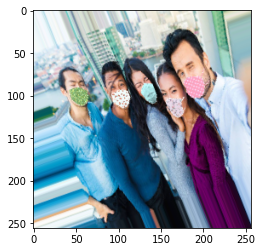

In [ ]:
# Printing some samples from the train dataset (just for test purposes)
import matplotlib.pyplot as plt
%matplotlib inline

batch=next(train_gen)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.imshow(img)   # shows the first image

(16, 256, 256, 3)
(256, 256, 3)


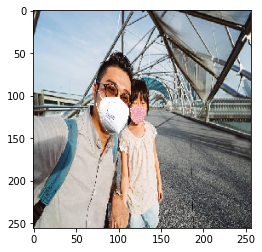

In [ ]:
# Printing some samples from the valid dataset (just for test purposes)
import matplotlib.pyplot as plt
%matplotlib inline

batch=next(valid_gen)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.imshow(img)   # shows the first image

In [ ]:
model = tf.keras.Sequential()

#CNN
# 1st block
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding='same',
    kernel_initializer='he_uniform',
    activation='relu',
    input_shape=[image_h, image_w, 3]
))
model.add(keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2)
))
model.add(tf.keras.layers.Dropout(0.2, seed=SEED))

# 2nd block
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    kernel_initializer='he_uniform'
))
model.add(keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2)
))
model.add(tf.keras.layers.Dropout(0.2, seed=SEED))

# 3rd block
model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    kernel_initializer='he_uniform'
))
model.add(keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2)
))
model.add(tf.keras.layers.Dropout(0.2, seed=SEED))

#FCN
# 1st block
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, kernel_initializer='he_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5, seed=SEED))

#output
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
# Optimization params
loss = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
# Validation metrics
metrics=['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Assignment_1/classification_experiments

In [ ]:
# Callbacks
cwd = '/content/drive/My Drive/Assignment_1'

exps_dir = os.path.join(cwd, 'classification_experiments')

if not os.path.exists(exps_dir):
  os.makedirs(exps_dir)


now = datetime.now().strftime('%b%d_%H-%M-%S') # taking instant time
exp_name = 'FC'                                # name of experiment
exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))


if not os.path.exists(exp_dir):
  os.makedirs(exp_dir)


callbacks = [] 

# Model checkpoint
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

#cp_{epoch:02d}
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True)

callbacks.append(ckpt_callback)

tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
  os.makedirs(tb_dir)


tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, histogram_freq=1)
callbacks.append(tb_callback)

# Early Stopping
early_stop = True
if early_stop:
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, min_delta=0, restore_best_weights=True)
  callbacks.append(es_callback)

In [ ]:
### training the model ###
model.fit(
    train_dataset,
    steps_per_epoch=num_elements_training // bs,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=valid_dataset,
    validation_steps=num_elements_validation // bs,
    initial_epoch=0
)

In [ ]:
# OPTIONAL (model saving)
model.save(saved_models_dir)

In [ ]:
# Helper function used for creating csv file
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
# Predicting the model and writing result into a csv by calling create_csv function
results = {}

predictions = model.predict(test_gen,
                            steps=num_elements_test,
                            verbose=1,
                            batch_size=bs)

predicted_class_indices=np.argmax(predictions,axis=1)

filenames = test_gen.filenames

prova = [e[7:] for e in filenames]

for i in range(0, num_elements_test):
  results[prova[i]] = predicted_class_indices[i]

create_csv(results=results, results_dir=test_dir)